### Задача по ANOVA (дисперсионный анализ)

**На этот раз ситуация следующая: вы работаете в приложении по доставке готовых продуктов. К вам пришел коллега с результатами двух тестов:**

 - **В первом тестировали разрешение фотографий блюд в приложении: пользователям показывались либо прямоугольные, либо новые квадратные.** 
 - **Во втором: была обновлена кнопка заказа, и часть юзеров видела старый вариант, а часть – новый.**
 
**Коллега пришел к вам с просьбой: он посмотрел на графики и предположил, что среди групп могут встретиться различия. Ваша задача – помочь ему проверить гипотезы, сделать соответствующие выводы на основе статистических тестов и принять решения.**

Задания:
1. Выберите метод, который предположительно подойдет в первом вопросе.
2. Проверьте, являются ли дисперсии внутри групп гомогенными.
3. Проведите тест на нормальность распределения.
4. Сравните средние в представленных группах.
5. Используйте критерий Тьюки и определите, между какими группами есть статистически значимые различия. 
6. Примите решение: какие картинки в итоге будем использовать?
7. Выберите метод для второго теста.
8. Визуализируйте распределение events для контрольной и тестовой групп. 
9. Посмотрите на описательные статистики events в разбивке по группе и по сегменту пользователя. 
10. Выберите формулу для модели, проведите тест.

**Описание данных:**

 **5_task_1:**

 - id – id клиента в эксперименте
 - group – в каком разрешении показывались картинки (A – прямоугольные 16:9, B – квадратные, C – прямоугольные 12:4)
 - events – сколько блюд суммарно было заказано за период

**5_task_2:**

 - id – id клиента в эксперименте
 - segment – сегмент (high/low)
 - group – вид кнопки (control – старая версия, test – новая версия)
 - events – сколько блюд суммарно было заказано за период

In [10]:
# Загружаем необходимые библиотеки

import pandas as pd
import numpy as np

import scipy.stats as ss
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.api import anova_lm
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)
import pingouin as pg

import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
# Считываем датафрейм

df_task1 = pd.read_csv('5_task_1.csv')

In [12]:
# Проверяем содержимое ДФ

df_task1.head()

,id,group,events
0,16046,A,14
1,18712,A,41
2,3268,A,30
3,22633,A,37
4,28071,A,38


In [13]:
df_task1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      30000 non-null  int64 
 1   group   30000 non-null  object
 2   events  30000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 703.2+ KB


In [14]:
df_task1.group.unique()

array(['A', 'B', 'C'], dtype=object)

In [15]:
# Создаем серии, группируя по каждому значению столбца "button"

A = df_task1.query("group == 'A'").events
B = df_task1.query("group == 'B'").events
C = df_task1.query("group == 'C'").events

**1. Нужно проверить, какой формат фотографий блюд является наилучшим, т.е. в какой из групп в среднем покупали больше всего. Всего пользователям показывались три варианта:**

 - A – прямоугольные 16:9
 - B – квадратные
 - C – прямоугольные 12:4
 
**Каким статистическим тестом нужно воспользоваться для сравнения средних в данном случае?**

 - сделаю вывод исключительно по графику
 - ANOVA **(+)**
 - посчитаю хи-квадрат
 - t-test

**2. Проверьте, являются ли дисперсии внутри групп примерно одинаковыми (гомогенными) с помощью теста Левена.**

In [16]:
# Через pigouin

pg.homoscedasticity(data=df_task1, dv="events", group="group")

,W,pval,equal_var
levene,2.26226,0.104133,True


In [17]:
# Через scipy

ss.levene(A, B, C)

LeveneResult(statistic=2.2622596339318037, pvalue=0.1041327199523974)

p-value > 0.05, не отклоняем нулевую гипотезу о гомоскедастичности дисперсий внутри групп

**3. Также убедитесь, что данные распределены нормально, применив тест Шапиро-Уилка. Перед применением критерия при проверке на нормальность обязательно сделайте семплирование (1000 наблюдений), так как на больших выборках могут получаться неверные результаты. Для воспроизводимости результата используйте параметр random_state=17 в методе sample.**

**Дополнительно: попробуйте посчитать тест Шапиро-Уилка без использования метода sample. Сравните  результат с normaltest, а также qq-графиками. Какой вывод можно сделать по совокупности этих методов?**

In [18]:
# Создаем рандомные выборки для групп

A_sampled = A.sample(1000, random_state=17)
B_sampled = B.sample(1000, random_state=17)
C_sampled = C.sample(1000, random_state=17)

In [19]:
# Проверка на нормальность через scipy 

print(ss.shapiro(A_sampled))
print(ss.shapiro(B_sampled))
print(ss.shapiro(C_sampled))

ShapiroResult(statistic=0.9973153471946716, pvalue=0.09609563648700714)
ShapiroResult(statistic=0.9980798363685608, pvalue=0.31768906116485596)
ShapiroResult(statistic=0.9981185793876648, pvalue=0.3359004259109497)


In [20]:
# через normaltest

print(ss.normaltest(A_sampled))
print(ss.normaltest(B_sampled))
print(ss.normaltest(C_sampled))

NormaltestResult(statistic=0.6421907772748111, pvalue=0.7253540571548922)
NormaltestResult(statistic=0.7993452547417171, pvalue=0.6705395263954472)
NormaltestResult(statistic=1.5761199866762348, pvalue=0.4547261118122219)


In [21]:
# Проверка на нормальность через scipy БЕЗ семплирования

print(ss.shapiro(A))
print(ss.shapiro(B))
print(ss.shapiro(C))

ShapiroResult(statistic=0.9989418387413025, pvalue=4.318870651331963e-06)
ShapiroResult(statistic=0.9990161061286926, pvalue=1.0504894817131571e-05)
ShapiroResult(statistic=0.9989210963249207, pvalue=3.3885160064528463e-06)


C:\Users\repin\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [22]:
# Проверка на нормальность через normaltest БЕЗ семплирования

print(ss.normaltest(A))
print(ss.normaltest(B))
print(ss.normaltest(C))

NormaltestResult(statistic=2.1034599402238734, pvalue=0.3493328906085719)
NormaltestResult(statistic=0.8410715800223014, pvalue=0.6566948749848232)
NormaltestResult(statistic=3.243725809054571, pvalue=0.19753037588314626)


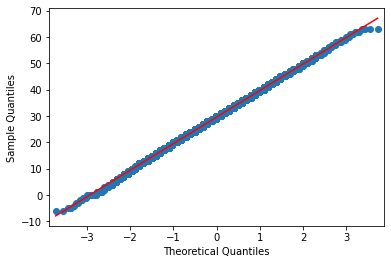

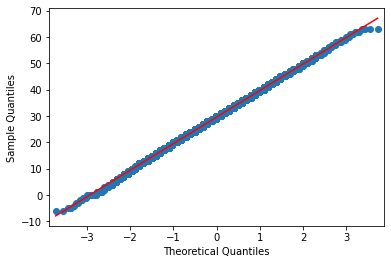

In [23]:
# Строим qqplot для А

sm.qqplot(A, line="r")

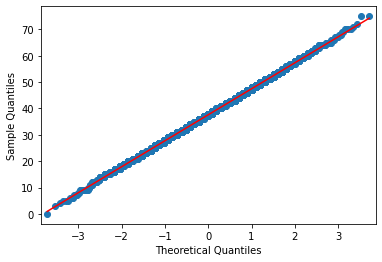

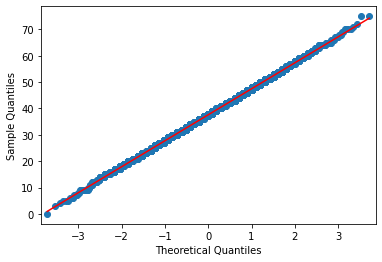

In [24]:
# Строим qqplot для B

sm.qqplot(B, line="r")

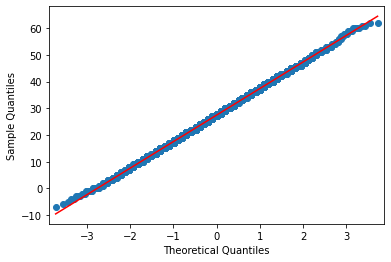

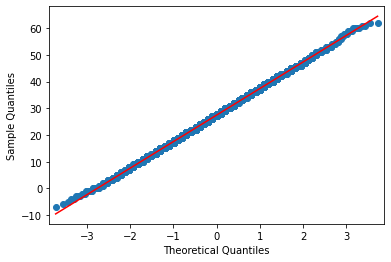

In [25]:
# Строим qqplot для C

sm.qqplot(C, line="r")

**Вывод: группы A, B, C имеют нормальное распределение значений, при этом метод .normaltest и .qqplot работает точнее, чем .shapiro на больших выборках**

**4. Сравните средние в представленных группах.**

In [26]:
# Через scipy

ss.f_oneway(A, B, C)

F_onewayResult(statistic=2886.166657438961, pvalue=0.0)

In [27]:
# Через pingouin

pg.anova(data=df_task1, dv="events", between="group")

,Source,ddof1,ddof2,F,p-unc,np2
0,group,2,29997,2886.166657,0.0,0.161377


In [28]:
# anova Уэлча в pingouin

pg.welch_anova(data=df_task1, dv="events", between="group")

,Source,ddof1,ddof2,F,p-unc,np2
0,group,2,19996.209267,2924.792424,0.0,0.161377


<AxesSubplot:xlabel='group', ylabel='events'>

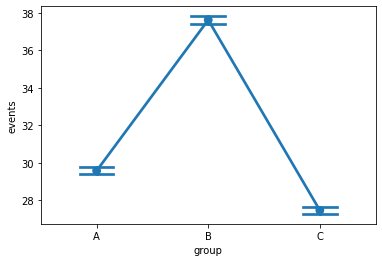

In [29]:
# средние с доверительными интервалами

sns.pointplot(x="group", y="events", data=df_task1, capsize = 0.3)

**Вывод: средние групп значимо различаются.**

**5. Теперь используйте критерий Тьюки и определите, между какими группами есть статистически значимые различия.** 

**Дополнительно: попробуйте другие варианты поправок на множественные сравнения через pingouin. Дают ли они те же выводы, что и Тьюки?**

In [30]:
# Критерий Тьюки

pg.pairwise_tukey(data=df_task1, dv="events", between="group")

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,A,B,29.5796,37.6136,-8.0340,0.140894,-57.021604,0.0,-0.806377
1,A,C,29.5796,27.4703,2.1093,0.140894,14.970833,0.0,0.211712
2,B,C,37.6136,27.4703,10.1433,0.140894,71.992436,0.0,1.018089


In [31]:
# с поправкой Бонферрони

pg.pairwise_tests(data=df_task1, dv="events", between="group", padjust="holm")

C:\Users\repin\AppData\Local\Programs\Python\Python310\lib\site-packages\pingouin\bayesian.py:152: RuntimeWarning: divide by zero encountered in double_scalars
  bf10 = 1 / ((1 + t**2 / df) ** (-(df + 1) / 2) / integr)
C:\Users\repin\AppData\Local\Programs\Python\Python310\lib\site-packages\pingouin\bayesian.py:152: RuntimeWarning: divide by zero encountered in double_scalars
  bf10 = 1 / ((1 + t**2 / df) ** (-(df + 1) / 2) / integr)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,group,A,B,False,True,-57.011134,19998.0,two-sided,0.000000e+00,0.000000e+00,holm,inf,-0.806229
1,group,A,C,False,True,14.886135,19998.0,two-sided,7.500262e-50,7.500262e-50,holm,1.054e+46,0.210514
2,group,B,C,False,True,72.420220,19998.0,two-sided,0.000000e+00,0.000000e+00,holm,inf,1.024138


In [32]:
# Геймс-хоувелл

pg.pairwise_gameshowell(data=df_task1, dv="events", between="group")

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,A,B,29.5796,37.6136,-8.0340,0.140920,-57.011134,19987.258491,6.412648e-13,-0.806229
1,A,C,29.5796,27.4703,2.1093,0.141696,14.886135,19995.116233,6.349254e-12,0.210514
2,B,C,37.6136,27.4703,10.1433,0.140062,72.420220,19995.502469,0.000000e+00,1.024138


**6. Так какие картинки в итоге будем использовать?**

**Ответ: квадратные картинки**

**7. Во втором эксперименте требуется проверить, как пользователи отреагируют на изменение формата кнопки оформления заказа, с разбивкой по сегменту клиента.**

**Какой метод скорее всего пригодится в данном случае?**

**Ответ: многофакторный дисперсионный анализ.**

In [33]:
# Считываем датафрейм

df_task2 = pd.read_csv('5_task_2.csv')

In [34]:
df_task2.head()

,id,group,segment,events
0,83440,test,high,78.0
1,96723,test,high,71.0
2,68719,test,high,80.0
3,50399,test,high,80.0
4,95613,test,high,78.0


In [35]:
df_task2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  int64  
 1   group    100000 non-null  object 
 2   segment  100000 non-null  object 
 3   events   100000 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.1+ MB


In [36]:
df_task2.group.unique()

array(['test', 'control'], dtype=object)

**8. Посмотрим на данные. Для начала визуализируйте распределение events для контрольной и тестовой групп. Соотнесите графики распределения и экспериментальные группы.**

In [37]:
# Создаем серии, группируя по каждому значению столбца "button"

test = df_task2.query("group == 'test'").events
control = df_task2.query("group == 'control'").events

In [38]:
# Настройка графиков по умолчанию
sns.set(
    font_scale =2,
    style      ="whitegrid",
    rc         ={'figure.figsize':(20,7)}
)

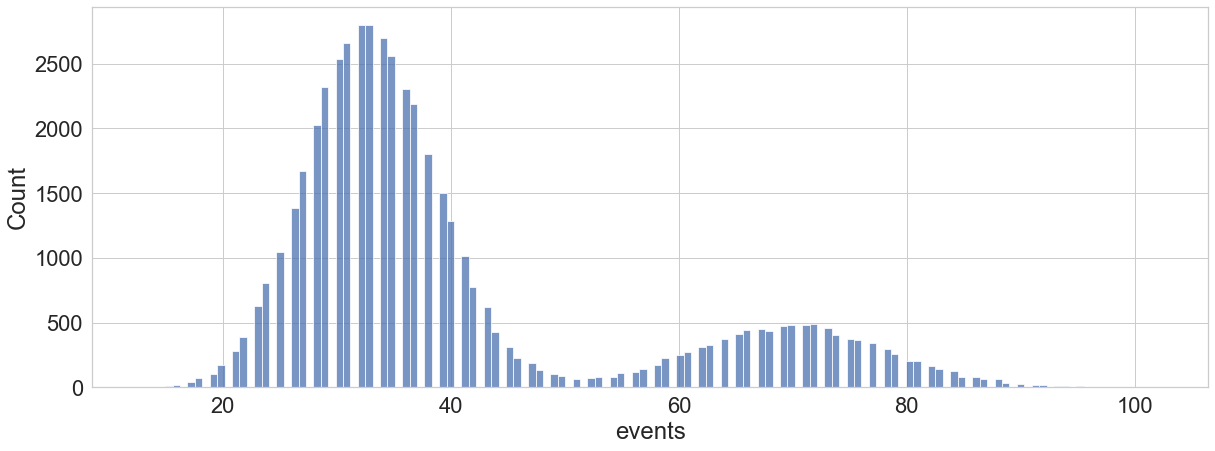

In [39]:
# Строим графики распределения

ax = sns.histplot(test)

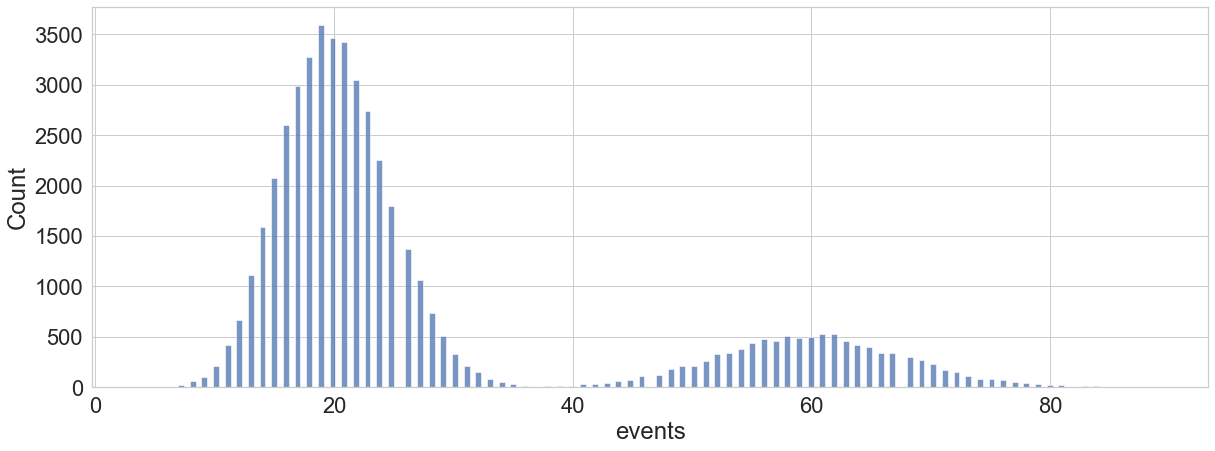

In [40]:
ax = sns.histplot(control)

**9. Посчитайте среднее, медиану и стандартное отклонение events в разбивке по группе и по сегменту пользователя.** 

**В качестве ответа укажите стандартное отклонение для пользователей из сегмента high и контрольной группы, с точностью до 2 знаков после точки.**

In [41]:
df_task2.groupby(['segment', 'group']).events.describe()

count       mean       std   min   25%   50%   75%    max
segment group                                                               
high    control  10000.0  59.970800  7.805347  31.0  55.0  60.0  65.0   89.0
        test     10000.0  69.938500  8.403974  40.0  64.0  70.0  76.0  102.0
low     control  40000.0  20.031575  4.473576   4.0  17.0  20.0  23.0   41.0
        test     40000.0  33.025925  5.720845  13.0  29.0  33.0  37.0   59.0

**Ответ: стандартное отклонение для пользователей из сегмента high и контрольной группы составляет 7.81**

**10. Почти у цели – осталось выбрать формулу для модели. Напомним, что мы хотим проверить эффект нескольких переменных – group и segment – на events, с взаимодействием факторов.**

**Если вы прибегнете к statsmodels, то какую формулу используете?**

In [42]:
df_task2

,id,group,segment,events
0,83440,test,high,78.0
1,96723,test,high,71.0
2,68719,test,high,80.0
3,50399,test,high,80.0
4,95613,test,high,78.0
...,...,...,...,...
99995,60695,control,low,15.0
99996,5934,control,low,16.0
99997,30046,control,low,22.0
99998,26474,control,low,21.0


In [49]:
# Через statsmodels

model_main = smf.ols("events ~ segment + group + segment*group", data=df_task2).fit()
anova_lm(model_main)

,df,sum_sq,mean_sq,F,PR(>F)
segment,1.0,2.362480e+07,2.362480e+07,689756.377484,0.000000e+00
group,1.0,3.837195e+06,3.837195e+06,112031.864119,0.000000e+00
segment:group,1.0,3.664244e+04,3.664244e+04,1069.823273,2.060261e-233
Residual,99996.0,3.424956e+06,3.425093e+01,NaN,NaN


In [51]:
model_main = smf.ols("events ~ segment + group + segment:group", data=df_task2).fit()
anova_lm(model_main)

,df,sum_sq,mean_sq,F,PR(>F)
segment,1.0,2.362480e+07,2.362480e+07,689756.377484,0.000000e+00
group,1.0,3.837195e+06,3.837195e+06,112031.864119,0.000000e+00
segment:group,1.0,3.664244e+04,3.664244e+04,1069.823273,2.060261e-233
Residual,99996.0,3.424956e+06,3.425093e+01,NaN,NaN


**11. Проведите тест (через anova_lm либо pg.anova), а затем используйте критерий Тьюки, чтобы понять между какими группами есть статистически значимые различия.**

**В данном случае для последующих сравнений между группами можно проделать следующую операцию: соединить колонки group и segment в combination, чтобы потом передать в аргумент groups в MultiComparison либо pairwise_tukey:**


| group | segment | combination |

| test  | high    | test / high |

| test  | high    | test / high |


**Между какими группами были обнаружены статистически значимые различия?**

In [45]:
df_task2['combination']= df_task2['group'] + ' / ' + df_task2['segment']

In [47]:
# сравнение между группами, способ №1

MultiComparison(df_task2.events, df_task2.combination).tukeyhsd().summary()

group1,group2,meandiff,p-adj,lower,upper,reject
control / high,control / low,-39.9392,-0.0,-40.1073,-39.7711,True
control / high,test / high,9.9677,-0.0,9.7551,10.1803,True
control / high,test / low,-26.9449,-0.0,-27.113,-26.7768,True
control / low,test / high,49.9069,-0.0,49.7388,50.075,True
control / low,test / low,12.9944,-0.0,12.888,13.1007,True
test / high,test / low,-36.9126,-0.0,-37.0807,-36.7445,True


In [48]:
# сравнение между группами, способ №2

pairwise_tukeyhsd(df_task2.events, df_task2.combination).summary()

group1,group2,meandiff,p-adj,lower,upper,reject
control / high,control / low,-39.9392,-0.0,-40.1073,-39.7711,True
control / high,test / high,9.9677,-0.0,9.7551,10.1803,True
control / high,test / low,-26.9449,-0.0,-27.113,-26.7768,True
control / low,test / high,49.9069,-0.0,49.7388,50.075,True
control / low,test / low,12.9944,-0.0,12.888,13.1007,True
test / high,test / low,-36.9126,-0.0,-37.0807,-36.7445,True


**12. Визуализируйте результаты теста**

<AxesSubplot:xlabel='group', ylabel='events'>

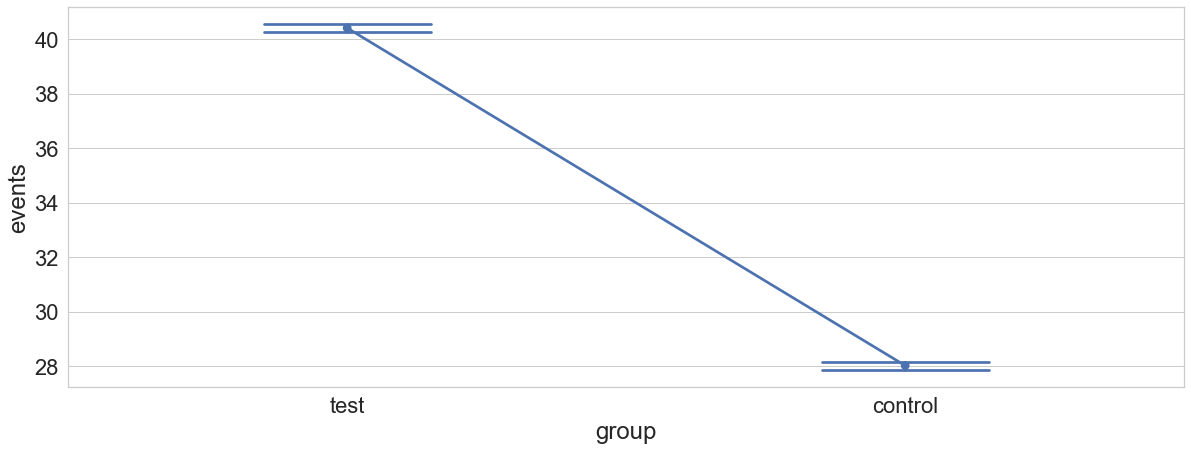

In [53]:
#первый фактор

sns.pointplot(x="group", y="events", data=df_task2, capsize=0.3)

<AxesSubplot:xlabel='segment', ylabel='events'>

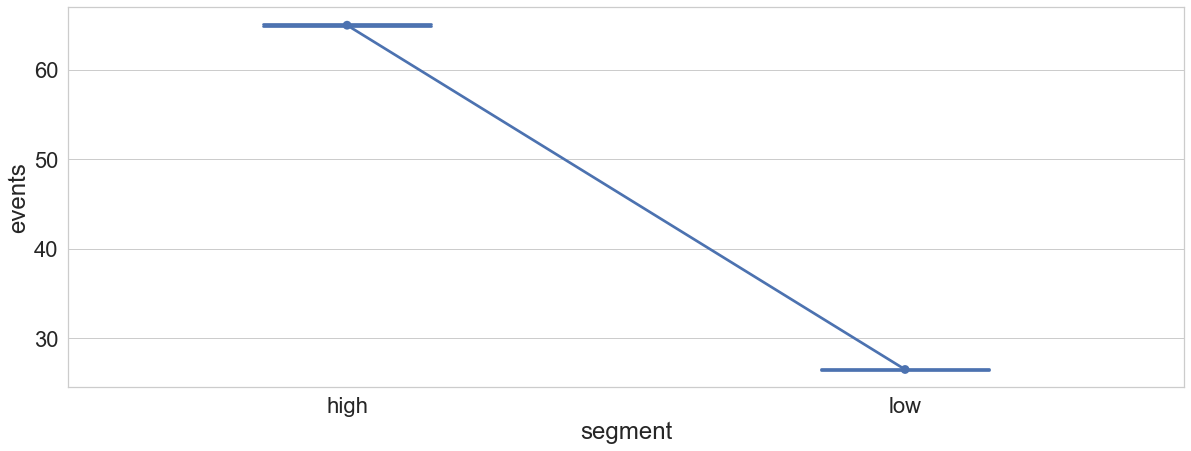

In [54]:
#второй фактор

sns.pointplot(x="segment", y="events", data=df_task2, capsize=0.3)

<AxesSubplot:xlabel='group', ylabel='events'>

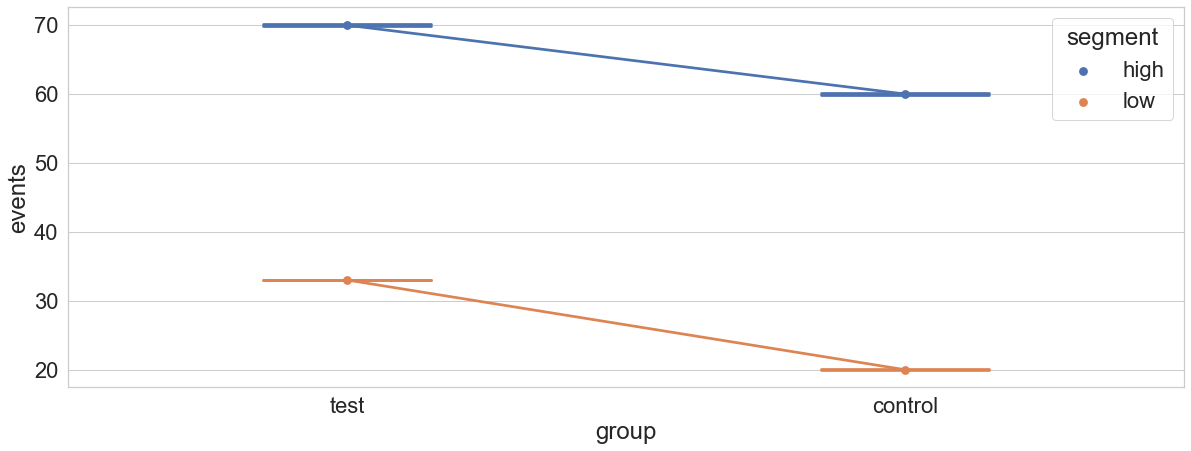

In [57]:
#взаимодействие факторов фактор

sns.pointplot(x="group", y="events",hue="segment", data=df_task2, capsize=0.3)

**Вывод: Фактор group оказался ЗНАЧИМЫМ, фактор segment – ЗНАЧИМЫМ, их взаимодействие – ЗНАЧИМО. Судя по графику, для всех групп среднее значение events УВЕЛИЧИЛОСЬ, поэтому решение: ВЫКАТЫВАЕМ НОВУЮ ВЕРСИЮ**